# TANDA on RoBERTa

## Setting up the environment

In [1]:
!mkdir -p /scratch/sagarsj42/torch-cache
!mkdir -p /scratch/sagarsj42/transformers
!mkdir -p /scratch/sagarsj42/hf-datasets

import os
os.chdir('/scratch/sagarsj42')
os.environ['TORCH_HOME'] = '/scratch/sagarsj42/torch-cache'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/sagarsj42/transformers'
os.environ['HF_DATASETS_CACHE'] = '/scratch/sagarsj42/hf-datasets'

## Imports

In [2]:
import random
import string
import copy

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import transformers
from transformers import RobertaTokenizer, RobertaModel

2021-12-12 02:21:16.107442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 02:21:16.107475: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
transformers.logging.set_verbosity_error()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Create, filter datasets

In [4]:
# Copied from explore_wikiqa.ipynb
def get_valid_questions(wikiqa):
    question_status = dict()

    for split in wikiqa:
        split_dataset = wikiqa[split]
        n_samples = len(split_dataset)

        for i in range(n_samples):
            qid = split_dataset[i]['question_id']
            label = split_dataset[i]['label']
            if qid not in question_status:
                question_status[qid] = label
            else:
                question_status[qid] = max(question_status[qid], label)

    valid_questions = set([qid for qid in question_status if question_status[qid] > 0])
    
    return valid_questions

In [5]:
class AS2Dataset(Dataset):
    def __init__(self, as2, name, tokenizer, max_length):
        super(AS2Dataset, self).__init__()
        self.as2 = as2
        self.name = name
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        if name == 'wikiqa':
            self.sentence_key = 'answer'
        else:
            self.sentence_key = 'sentence'
        
    def __len__(self):
        return len(self.as2)
    
    def __getitem__(self, idx):
        sample = self.as2[idx]
        question = sample['question'].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        sentence = sample[self.sentence_key].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        label = torch.zeros(2)
        label[sample['label']] = 1.0
#         label = sample['label'] * 1.0
        
        input_enc = tokenizer(text=question, text_pair=sentence, 
                              add_special_tokens=True, truncation=True, padding='max_length', 
                              max_length=self.max_length, 
                              return_tensors='pt', return_attention_mask=True, return_token_type_ids=True)
        
        if self.name == 'wikiqa':
            return (sample['question_id'], question, sentence, 
                    input_enc['input_ids'].flatten(), input_enc['attention_mask'].flatten(), 
                    input_enc['token_type_ids'].flatten(), 
                    label)
        else:
            return (question, sentence, input_enc['input_ids'].flatten(), 
                    input_enc['attention_mask'].flatten(), input_enc['token_type_ids'].flatten(), 
                    label)

In [6]:
class TandaTransfer(nn.Module):
    def __init__(self, encoder):
        super(TandaTransfer, self).__init__()
        self.encoder = encoder
        self.layers = nn.Sequential(
            nn.Linear(768, 2),
            nn.Dropout(p=0.25)
        )
        
    def forward(self, x):
        a = x[1]
        x = self.encoder(input_ids=x[0], attention_mask=x[1], token_type_ids=x[2]).last_hidden_state
        x = (x * a.unsqueeze(-1) / a.sum(1).view(-1, 1, 1)).sum(1)
        x = self.layers(x)
        
        return x

## Architecture used in Adapt step

In [7]:
# Copied from bert_finetuning.ipynb
class BertQA(nn.Module):
    def __init__(self, encoder):
        super(BertQA, self).__init__()
        self.encoder = encoder
        self.layers = nn.Sequential(
            nn.Linear(768, 512),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(512, 2),
            nn.Dropout(p=0.15),
        )
        
    def forward(self, x):
        a = x[1]
        x = self.encoder(input_ids=x[0], attention_mask=x[1], token_type_ids=x[2]).last_hidden_state
        x = (x * a.unsqueeze(-1) / a.sum(1).view(-1, 1, 1)).sum(1)
        x = self.layers(x)
        
        return x

## Load & filter ASNQ

In [8]:
asnq = datasets.load_dataset('asnq')
asnq

In [9]:
asnq_f = asnq.filter(lambda sample: 
                     sample['sentence_in_long_answer'] or sample['short_answer_in_sentence'])
asnq_f.save_to_disk('asnq-2-3')
asnq_f

In [50]:
asnq_f = datasets.load_from_disk('asnq-2-3')
asnq_f

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 931448
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 59658
    })
})

### Sample 10,000/400 for testing in notebook

In [51]:
train_indices = random.sample(range(len(asnq_f['train'])), 10000)
dev_indices = random.sample(range(len(asnq_f['validation'])), 400)

asnq_ff = dict()
asnq_ff['train'] = asnq_f['train'].select(train_indices)
asnq_ff['validation'] = asnq_f['validation'].select(dev_indices)
asnq_f = asnq_ff
asnq_f

{'train': Dataset({
     features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
     num_rows: 10000
 }),
 'validation': Dataset({
     features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
     num_rows: 400
 })}

## Tokenizer & Encoder

In [8]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
encoder = RobertaModel.from_pretrained('roberta-base')
encoder

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

## Distribution of token lengths

In [52]:
tok_lengths = list()

for sample in asnq_f['train']:
    question = sample['question']
    sentence = sample['sentence']
    tok_len = min(256, len(tokenizer(text=question, text_pair=sentence)['input_ids']))
    tok_lengths.append(tok_len)
    
len(tok_lengths)

10000

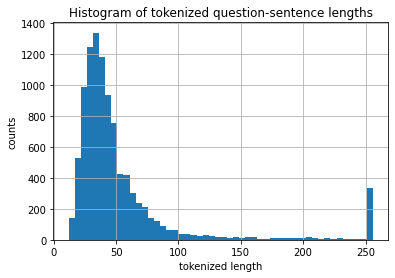

In [53]:
plt.hist(tok_lengths, density=False, bins=50)
plt.xlabel('tokenized length')
plt.ylabel('counts')
plt.title('Histogram of tokenized question-sentence lengths')
plt.grid()
plt.show()

## Setup for transfer step

In [9]:
batch_size = 16
transfer_epochs = 1
transfer_learning_rate = 1e-6

pos_weight=torch.tensor([1.0, 16.0], dtype=torch.float).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion

BCEWithLogitsLoss()

In [55]:
def train_epochs_asnq(n_epochs, dataloader, model, optimizer, criterion, 
                      dev_dataloader=None, eval_steps=10000, save_path='./best.pth', device='cpu'):
    model.train()
    n_batches = len(dataloader)
    best_loss = float('inf')
    
    for epoch in range(n_epochs):
        total_loss = 0.0
        for step, sample in enumerate(dataloader):
            sample = sample[2:6]
            sample = [s.to(device) for s in sample]
            optimizer.zero_grad()
            output = model(sample[:-1])
            loss = criterion(output, sample[-1])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if step > 0 and step % eval_steps == 0:
                dev_loss = validate_asnq(dev_dataloader, model, criterion, device=device)
                if dev_loss < best_loss:
                    best_loss = dev_loss
                    save_dict = {
                        'epoch': epoch+1,
                        'step': step,
                        'dev_loss': dev_loss,
                        'model_params': model.state_dict()
                    }
                    torch.save(save_dict, save_path)
                    print(f'Best checkpoint saved at epoch {epoch+1}, step {step}, dev loss: {dev_loss:.4f}')
                step_loss = 0.0
        
        save_dict = {
                    'epoch': epoch,
                    'step': step,
                    'dev_loss': dev_loss,
                    'model_params': model.state_dict()
                    }
        torch.save(save_dict, 'test-final-transfer.pth')
        total_loss /= n_batches
        print(f'Epoch {epoch+1} complete. Train loss: {total_loss:.4f}')
    
    return total_loss

def validate_asnq(dataloader, model, criterion, device='cpu'):
    model.eval()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = sample[2:6]
        sample = [s.to(device) for s in sample]
        output = model(sample[:-1])
        loss = criterion(output, sample[-1])
        total_loss += loss.item()
        
    return total_loss / n_batches

In [56]:
asnq_train_ds = AS2Dataset(asnq_f['train'], 'asnq', tokenizer, max_length=128)
asnq_dev_ds = AS2Dataset(asnq_f['validation'], 'asnq', tokenizer, max_length=128)

len(asnq_train_ds), len(asnq_dev_ds)

(10000, 400)

In [57]:
asnq_train_dl = DataLoader(asnq_train_ds, batch_size=batch_size, shuffle=True)
asnq_dev_dl = DataLoader(asnq_dev_ds, batch_size=batch_size, shuffle=False)

len(asnq_train_dl), len(asnq_dev_dl)

(625, 25)

In [19]:
model = TandaTransfer(encoder)
model.to(DEVICE)
model = nn.DataParallel(model)

optimizer = Adam(model.parameters(), lr=transfer_learning_rate)

### Complete transfer step

In [20]:
train_loss = train_epochs_asnq(transfer_epochs, asnq_train_dl, model, optimizer, criterion, 
                               dev_dataloader=asnq_dev_dl, eval_steps=100, save_path='test-best-transfer.pth', 
                               device=DEVICE)
train_loss

Best checkpoint saved at epoch 1, step 100, dev loss: 0.9758
Best checkpoint saved at epoch 1, step 200, dev loss: 0.9225
Best checkpoint saved at epoch 1, step 300, dev loss: 0.9062
Best checkpoint saved at epoch 1, step 400, dev loss: 0.8850
Best checkpoint saved at epoch 1, step 500, dev loss: 0.8782
Best checkpoint saved at epoch 1, step 600, dev loss: 0.8632
Epoch 1 complete. Train loss: 0.8441


0.844081067609787

## Load best checkpoint from transfer step

In [10]:
model = TandaTransfer(encoder)
save_dict = torch.load('best-transfer-roberta.pth')
model.load_state_dict(save_dict['model_params'], strict=False)
model

TandaTransfer(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((76

In [11]:
wikiqa = datasets.load_dataset('wiki_qa')
valid_questions = get_valid_questions(wikiqa)
wikiqa_f = wikiqa.filter(lambda sample: sample['question_id'] in valid_questions)

wikiqa_f

Using the latest cached version of the module from /home2/sagarsj42/.cache/huggingface/modules/datasets_modules/datasets/wiki_qa/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c (last modified on Sat Nov 20 13:05:25 2021) since it couldn't be found locally at /scratch/sagarsj42/wiki_qa/wiki_qa.py, or remotely (ConnectionError).
Using custom data configuration default
Reusing dataset wiki_qa (/scratch/sagarsj42/hf-datasets/wiki_qa/default/0.1.0/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c)


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 2351
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 1130
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 8672
    })
})

## Setup for adapt setp

In [12]:
adapt_learning_rate = 5e-6
adapt_epochs = 10

pos_weight=torch.tensor([1.0, 8.0], dtype=torch.float).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss()
criterion

BCEWithLogitsLoss()

In [13]:
model = BertQA(model.encoder)
model.to(DEVICE)

optimizer = Adam(model.parameters(), lr=adapt_learning_rate, betas=(0.9, 0.999), eps=1e-7)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-07
    lr: 5e-06
    weight_decay: 0
)

In [14]:
wikiqa_train_ds = AS2Dataset(wikiqa_f['train'], 'wikiqa', tokenizer, max_length=64)
wikiqa_dev_ds = AS2Dataset(wikiqa_f['validation'], 'wikiqa', tokenizer, max_length=64)
wikiqa_test_ds = AS2Dataset(wikiqa_f['test'], 'wikiqa', tokenizer, max_length=64)

len(wikiqa_train_ds), len(wikiqa_dev_ds), len(wikiqa_test_ds)

(8672, 1130, 2351)

In [15]:
wikiqa_train_dl = DataLoader(wikiqa_train_ds, batch_size=batch_size, shuffle=True)
wikiqa_dev_dl = DataLoader(wikiqa_dev_ds, batch_size=batch_size, shuffle=False)
wikiqa_test_dl = DataLoader(wikiqa_test_ds, batch_size=batch_size, shuffle=False)

len(wikiqa_train_dl), len(wikiqa_dev_dl), len(wikiqa_test_dl)

(542, 71, 147)

In [16]:
# Copied from bert_finetuning.ipynb

def train_epoch(dataloader, model, optimizer, criterion, device='cpu'):
    model.train()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = sample[3:7]
        sample = [s.to(device) for s in sample]
        optimizer.zero_grad()
        output = model(sample[:-1])
        loss = criterion(output, sample[-1])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / n_batches

def validate(dataloader, model, criterion, device='cpu'):
    model.eval()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = sample[3:7]
        sample = [s.to(device) for s in sample]
        output = model(sample[:-1])
        loss = criterion(output, sample[-1])
        total_loss += loss.item()
        
    return total_loss / n_batches

def get_scores(dataloader, model, device='cpu'):
    model.eval()
    eval_results = list()
    
    for batch in dataloader:
        batch = copy.deepcopy(batch)
        batch_d = [b.to(device) for b in batch[3:6]]
        output = model(batch_d).detach()[:, 1]
#         output = model(batch_d).detach()
        scores = nn.Sigmoid()(output)
        
        batch[-1] = batch[-1][:, 1].tolist()
#         batch[-1] = batch[-1].tolist()
        batch.append(scores.tolist())
        size = len(batch[0])
        eval_results.extend([[b[i] for b in batch] for i in range(size)])
        
    return eval_results

def get_question_label_scores(results):
    q_dict = dict()
    
    for result in results:
        qid = result[0]
        if qid in q_dict:
            q_dict[qid][1].append(result[2])
            q_dict[qid][2].append(result[6])
            q_dict[qid][3].append(result[7])
        else:
            q_dict[qid] = [result[1], [result[2]], [result[6]], [result[7]]]
            
    return q_dict

def calculate_metrics(question_scores):
    total = len(question_scores) * 1.0
    accuracy = 0
    mrr = 0.0
    all_labels = list()
    all_scores = list()
    
    for qid, values in question_scores.items():
        values = copy.deepcopy(values)
        labels = values[2]
        scores = values[3]
        all_labels.extend(labels)
        all_scores.extend(scores)
        actual = np.array(labels).argmax()
        predicted = np.array(scores).argmax()
        expected_max = scores[actual]
        scores.sort(reverse=True)
        given_rank = scores.index(expected_max) + 1
        
        if actual == predicted:
            accuracy += 1
        mrr += (1.0/given_rank)
        
    accuracy /= total
    mean_ap = average_precision_score(all_labels, all_scores)
    mrr /= total
    
    return accuracy, mean_ap, mrr

def plot_curves(train_stats, dev_stats, index, title):
    n_epochs = len(train_stats)+1
    plt.plot(range(1, n_epochs), [s[index] for s in train_stats])
    plt.plot(range(1, n_epochs), [s[index] for s in dev_stats])
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(f'Comparison of {title} variation over epochs')
    plt.legend(['train', 'dev'])
    plt.grid()
    plt.show()
    
    return

### Complete & evaluate adapt step

In [17]:
best_mrr = float('-inf')
best_model = None
train_stats = list()
dev_stats = list()

for epoch in range(adapt_epochs):
    train_loss = train_epoch(wikiqa_train_dl, model, optimizer, criterion, device=DEVICE)
    dev_loss = validate(wikiqa_dev_dl, model, criterion, device=DEVICE)
    
    train_results = get_scores(wikiqa_train_dl, model, device=DEVICE)
    train_qscores = get_question_label_scores(train_results)
    train_acc, train_map, train_mrr = calculate_metrics(train_qscores)
    train_stats.append((train_loss, train_acc, train_map, train_mrr))
    
    dev_results = get_scores(wikiqa_dev_dl, model, device=DEVICE)
    dev_qscores = get_question_label_scores(dev_results)
    dev_acc, dev_map, dev_mrr = calculate_metrics(dev_qscores)
    dev_stats.append((dev_loss, dev_acc, dev_map, dev_mrr))
    
    if dev_mrr > best_mrr:
        best_mrr = dev_mrr
        best_model = copy.deepcopy(model)
    
    print(f'Epoch {epoch+1} complete. Train loss: {train_loss:.4f}, Dev loss: {dev_loss:.4f}')
    print(f'Accuracy: train = {train_acc}, dev = {dev_acc}')
    print(f'MAP: train = {train_map}, dev = {dev_map}')
    print(f'MRR: train = {train_mrr}, dev = {dev_mrr}')
    print('-'*80)
    
save_dict = {'model_params': best_model.state_dict(), 
             'train_stats': train_stats, 
             'dev_stats': dev_stats
            }
torch.save(save_dict, 'best-wikiqa-adapt-roberta.pth')

Epoch 1 complete. Train loss: 0.7382, Dev loss: 0.5953
Accuracy: train = 0.572737686139748, dev = 0.6111111111111112
MAP: train = 0.5976749567852111, dev = 0.541071912705301
MRR: train = 0.735087874048904, dev = 0.7420262717881766
--------------------------------------------------------------------------------
Epoch 2 complete. Train loss: 0.5969, Dev loss: 0.5401
Accuracy: train = 0.695303550973654, dev = 0.6666666666666666
MAP: train = 0.7343812105840383, dev = 0.6105640393442809
MRR: train = 0.8244259399757681, dev = 0.7825179229941137
--------------------------------------------------------------------------------
Epoch 3 complete. Train loss: 0.5231, Dev loss: 0.5022
Accuracy: train = 0.7548682703321878, dev = 0.6904761904761905
MAP: train = 0.8232071085981452, dev = 0.6544367423261173
MRR: train = 0.8607275090952072, dev = 0.8030706727135298
--------------------------------------------------------------------------------
Epoch 4 complete. Train loss: 0.4523, Dev loss: 0.5241
Accu

In [18]:
save_dict = torch.load('best-wikiqa-adapt-roberta.pth')
train_stats = save_dict['train_stats']
dev_stats = save_dict['dev_stats']
save_dict.keys()

dict_keys(['model_params', 'train_stats', 'dev_stats'])

In [19]:
model = BertQA(encoder)
model.load_state_dict(save_dict['model_params'], strict=False)
model.to(DEVICE)

BertQA(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

In [20]:
test_loss = validate(wikiqa_test_dl, model, criterion, device=DEVICE)
test_loss

0.5058435954559012

In [21]:
test_results = get_scores(wikiqa_test_dl, model, device=DEVICE)
test_qscores = get_question_label_scores(test_results)
test_acc, test_map, test_mrr = calculate_metrics(test_qscores)

print(f'Test data: Accuracy = {test_acc}, MAP = {test_map}, MRR = {test_mrr}')

Test data: Accuracy = 0.7613168724279835, MAP = 0.6615303951897219, MRR = 0.8548402900254752


## Additional visualizations for adapt step

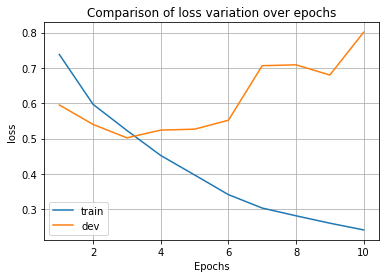

In [22]:
plot_curves(train_stats, dev_stats, 0, 'loss')

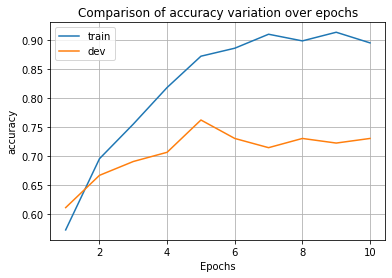

In [23]:
plot_curves(train_stats, dev_stats, 1, 'accuracy')

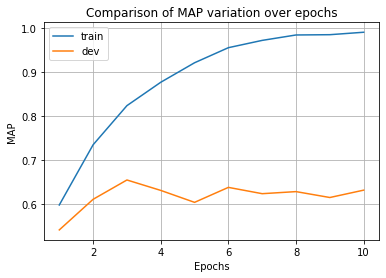

In [24]:
plot_curves(train_stats, dev_stats, 2, 'MAP')

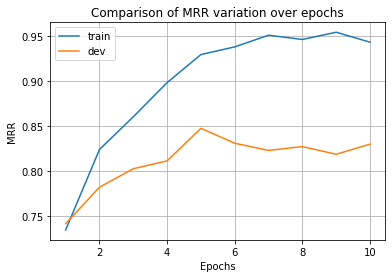

In [25]:
plot_curves(train_stats, dev_stats, 3, 'MRR')

In [26]:
for t in train_stats:
    print(t[0], '\t', t[1], '\t', t[2], '\t', t[3])

0.7382473317129585 	 0.572737686139748 	 0.5976749567852111 	 0.735087874048904
0.5968973624805243 	 0.695303550973654 	 0.7343812105840383 	 0.8244259399757681
0.523059469527424 	 0.7548682703321878 	 0.8232071085981452 	 0.8607275090952072
0.45230761481057236 	 0.8178694158075601 	 0.8762870156935043 	 0.8987208858342881
0.39724679156533027 	 0.8717067583046965 	 0.9205925368545422 	 0.9298696339933457
0.3415711637881904 	 0.8854524627720504 	 0.9548026590957472 	 0.9383925162275679
0.30356810811728346 	 0.9095074455899198 	 0.9713760814177863 	 0.9513554791905309
0.2816589982334758 	 0.8980526918671249 	 0.9836527849882036 	 0.9466208476517753
0.26074510648832877 	 0.9129438717067583 	 0.9842978427502663 	 0.9546582665139365
0.24169405755961512 	 0.8946162657502864 	 0.9898553430250996 	 0.9436044291714396


In [27]:
for t in dev_stats:
    print(t[0], '\t', t[1], '\t', t[2], '\t', t[3])

0.5953241309649507 	 0.6111111111111112 	 0.541071912705301 	 0.7420262717881766
0.5400824443974965 	 0.6666666666666666 	 0.6105640393442809 	 0.7825179229941137
0.5022027801040193 	 0.6904761904761905 	 0.6544367423261173 	 0.8030706727135298
0.524127806995956 	 0.7063492063492064 	 0.6307667813941027 	 0.8117472915091963
0.5267142435981774 	 0.7619047619047619 	 0.6036477890676998 	 0.847905643738977
0.551958340075864 	 0.7301587301587301 	 0.637648630424505 	 0.8313807004283195
0.7063694090884126 	 0.7142857142857143 	 0.6233303767683447 	 0.8233560090702948
0.7087690069300818 	 0.7301587301587301 	 0.6280372224949804 	 0.8276549508692366
0.6799817128552937 	 0.7222222222222222 	 0.6146489703138056 	 0.8191137566137566
0.801000411425468 	 0.7301587301587301 	 0.6313573783787143 	 0.8303571428571429
